In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('kmeans_3D_point').getOrCreate()

In [5]:
# Loads data.
data = spark.read.csv("data3D.csv", header=True, inferSchema=True)

In [6]:
data.show(3)

+------+-----------------+------------------+------------------+
|    id|                x|                 y|                 z|
+------+-----------------+------------------+------------------+
|point0|5.647627534046943|-6.356222340123802|-7.240816026826695|
|point1|4.414367138680041|-10.32624175635328| 8.963324308916228|
|point2|5.005396944639823|-9.301070062115645| 10.35473056351597|
+------+-----------------+------------------+------------------+
only showing top 3 rows



In [7]:
from pyspark.sql.functions import col

In [8]:
data = data.select(['x', 'y', 'z'])

In [9]:
data.show(3)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



### Format from data

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
data.columns

['x', 'y', 'z']

In [12]:
vec_assembler = VectorAssembler(inputCols = data.columns, outputCol='features')

In [13]:
final_data = vec_assembler.transform(data)

### Scale the Data

In [14]:
from pyspark.ml.feature import StandardScaler

In [15]:
scaler = StandardScaler(inputCol="features", 
 outputCol="scaledFeatures", 
 withStd=True, 
 withMean=False)

In [16]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [17]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [18]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

### Train the Model and Evaluate


#### Seleck k with minimun WSSSE: k between 2 - 10


In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [20]:
# Trains a k-means model.
k_list = []
silhouette_list = []
for k in range(2,11): 
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    predictions  = model.transform(final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    k_list.append(k)
    silhouette_list.append(silhouette)
    print("With k =", k, "Set Sum of Silhouette = " + str(silhouette))

With k = 2 Set Sum of Silhouette = 0.4700835660754401
With k = 3 Set Sum of Silhouette = 0.9407566693614594
With k = 4 Set Sum of Silhouette = 0.6424281728628255
With k = 5 Set Sum of Silhouette = 0.8066317792943369
With k = 6 Set Sum of Silhouette = 0.7416364675117402
With k = 7 Set Sum of Silhouette = 0.6357503727099628
With k = 8 Set Sum of Silhouette = 0.5296094670379646
With k = 9 Set Sum of Silhouette = 0.6207395388828445
With k = 10 Set Sum of Silhouette = 0.45525732430807186


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

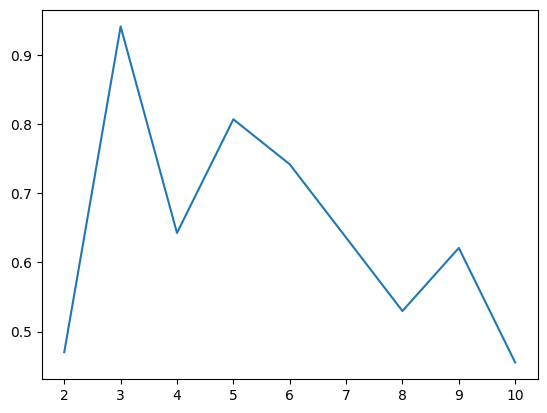

In [22]:
plt.plot(k_list, silhouette_list)
plt.show()

- According to Elbow Method, we choose k = 5. Look like there is very little gain after k=5, so
we stick to that choice when processing the full data set.


#### Select k = 5


In [23]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=5)
model = kmeans.fit(final_data)

In [24]:
# silhoutte
predictions = model.transform(final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhoutte = " + str(silhouette))

Silhoutte = 0.8066317792943369


Within Set Sum of Squared Errors = 72720.18504204816 

In [25]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-1.73339969  0.93730245  0.31607309]
[ 0.77554585 -0.80820119 -1.03388802]
[-1.44535059  0.93733532  0.31598624]
[-0.45130771  1.1537552   0.72387354]
[ 0.74896823 -1.2269015   1.46702482]


In [26]:
predictions = model.transform(final_data)

In [27]:
predictions.select("prediction").show(5)

+----------+
|prediction|
+----------+
|         1|
|         4|
|         4|
|         4|
|         0|
+----------+
only showing top 5 rows



In [28]:
# Check number points of each cluster

In [29]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|400000|
|         3|199828|
|         4|200000|
|         2| 99833|
|         0|100339|
+----------+------+



In [30]:
# Our clustering algorithm created 5 equally sized clusters with K=5

In [31]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [32]:
type(data_result)

pyspark.sql.dataframe.DataFrame

In [33]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

In [35]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()


In [36]:
temp.show(3)

+------------------+-------------------+-------------------+
|                _1|                 _2|                 _3|
+------------------+-------------------+-------------------+
|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|
|0.7941127247055376| -1.321371532702518|  1.398892340103383|
|0.9004347126254749|-1.1901880174546229|  1.616046989924021|
+------------------+-------------------+-------------------+
only showing top 3 rows



In [37]:
import pyspark.sql.functions as f

In [38]:
# since there is no common column between these two dataframes add row_index so t
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
data_result=data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")

In [39]:
temp = temp.select(col("_1").alias("x_scale"), 
                   col("_2").alias("y_scale"), 
                   col("_3").alias("z_scale"), 
                   "prediction")

In [40]:
df = temp.toPandas()

In [41]:
df.head(3)

,x_scale,y_scale,z_scale,prediction
0,1.015967,-0.813358,-1.130063,1
1,0.794113,-1.321372,1.398892,4
2,0.900435,-1.190188,1.616047,4


In [42]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2
0,-1.733400,0.937302,0.316073
1,0.775546,-0.808201,-1.033888
2,-1.445351,0.937335,0.315986
3,-0.451308,1.153755,0.723874
4,0.748968,-1.226902,1.467025


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

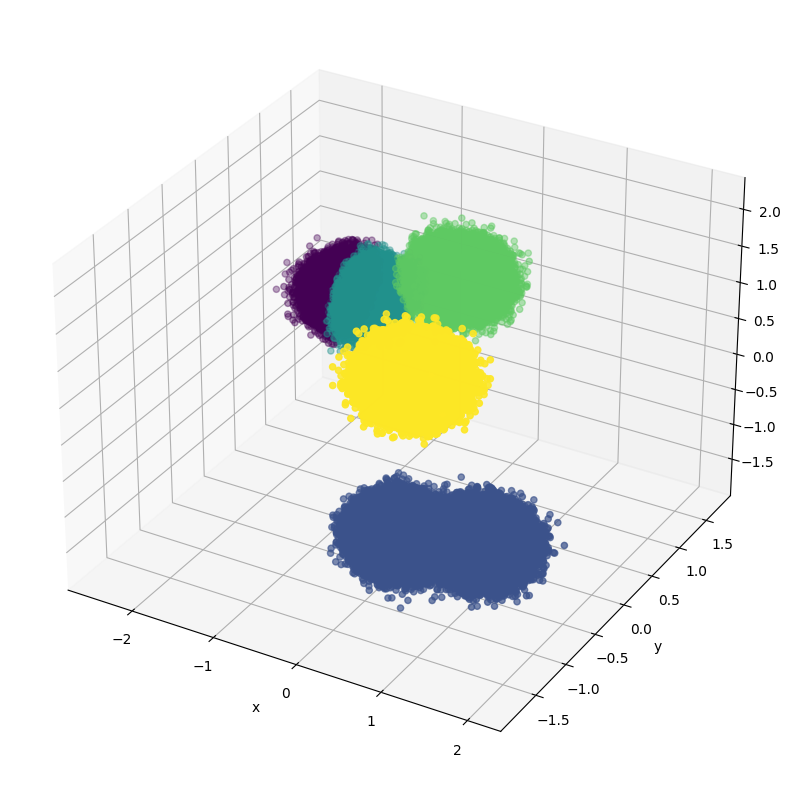

In [44]:
threedee = plt.figure(figsize=(12,10)).add_subplot(projection='3d')
threedee.scatter(df.x_scale, df.y_scale, 
                 df.z_scale, 
                 c=df.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

### Combine results

In [45]:
# since there is no common column between these two dataframes add row_index so t
final_data=final_data.withColumn('row_index', f.monotonically_increasing_id())
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
final_data = final_data.join(temp, on=["row_index"]).sort("row_index").drop("row_index")

In [46]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |x_scale           |y_scale            |z_scale            |prediction|
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|1         |
|4.414367138